In [1]:
import pandas as pd
data_train = pd.read_csv('sarcasm_mal_train.csv')
data_val = pd.read_csv('sarcasm_mal_dev.csv')
data_test = pd.read_csv('sarcasm_mal_test.csv')

In [2]:
text_train = data_train['Text']
text_val = data_val['Text']
text_test = data_test['Text']

class_label_train = data_train['labels']
class_label_val = data_val['labels']
class_label_test = data_test['labels']

In [3]:
class_label_train.value_counts(), class_label_val.value_counts()

(labels
 Non-sarcastic    10689
 Sarcastic         2499
 Name: count, dtype: int64,
 labels
 Non-sarcastic    2305
 Sarcastic         521
 Name: count, dtype: int64)

In [4]:
import numpy as np
classes_list = ["Non-sarcastic", "Sarcastic"]
label_index_train = class_label_train.apply(classes_list.index)
label_index_val = class_label_val.apply(classes_list.index)
label_index_test = class_label_test.apply(classes_list.index)

In [5]:
import numpy as np
import ktrain
from ktrain import text

In [6]:
MODEL_NAME = 'distilbert-base-multilingual-cased'
# MODEL_NAME = 'google-bert/bert-base-multilingual-cased'
# MODEL_NAME = 'roberta-base'
t = text.Transformer(MODEL_NAME, maxlen=30, classes=classes_list)
trn = t.preprocess_train(np.array(text_train), np.array(class_label_train))
val = t.preprocess_test(np.array(text_val), np.array(class_label_val))
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

c:\Users\nimmi\anaconda3\Lib\site-packages\ktrain\text\preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


preprocessing train...
language: ml
train sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 47


c:\Users\nimmi\anaconda3\Lib\site-packages\ktrain\utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: ml
test sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 45


In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
token_counts = [len(tokenizer.tokenize(text)) for text in text_train]
max_tokens_in_dataset = max(token_counts)
print(f"The maximum number of tokens in the dataset is {max_tokens_in_dataset}")

average_tokens = np.mean(token_counts)
print(f"The average number of tokens in the dataset is {average_tokens:.2f}")

token_counts = [len(tokenizer.tokenize(text)) for text in text_val]
max_tokens_in_dataset = max(token_counts)
print(f"The maximum number of tokens in the dataset is {max_tokens_in_dataset}")
# Calculate the average number of tokens
average_tokens = np.mean(token_counts)
print(f"The average number of tokens in the dataset is {average_tokens:.2f}")


token_counts = [len(tokenizer.tokenize(text)) for text in text_test]
max_tokens_in_dataset = max(token_counts)
print(f"The maximum number of tokens in the dataset is {max_tokens_in_dataset}")
# Calculate the average number of tokens
average_tokens = np.mean(token_counts)
print(f"The average number of tokens in the dataset is {average_tokens:.2f}")

The maximum number of tokens in the dataset is 963
The average number of tokens in the dataset is 34.07
The maximum number of tokens in the dataset is 811
The average number of tokens in the dataset is 33.90
The maximum number of tokens in the dataset is 816
The average number of tokens in the dataset is 33.53


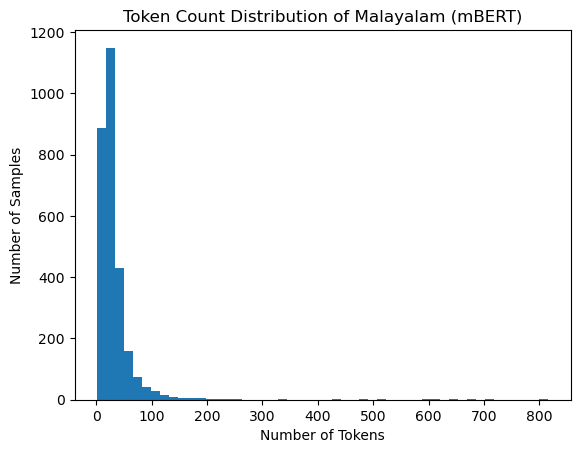

In [10]:
import matplotlib.pyplot as plt

plt.hist(token_counts, bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Samples')
plt.title('Token Count Distribution of Malayalam (mBERT)')
plt.show()

In [7]:
# from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "malayalam_googlebert"

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [27]:
# learner.fit_onecycle(5e-5, 15, verbose=2, callbacks=callbacks_list)

In [8]:
model.load_weights(filepath)

learner.validate(class_names=t.get_classes())

predictor = ktrain.get_predictor(learner.model, preproc=t)

predict = predictor.predict(text_test.values)

89/89 [==============================] - 415s 4s/step
               precision    recall  f1-score   support

Non-sarcastic       0.88      0.96      0.92      2305
    Sarcastic       0.68      0.40      0.50       521

     accuracy                           0.85      2826
    macro avg       0.78      0.68      0.71      2826
 weighted avg       0.84      0.85      0.84      2826



In [9]:
from keras.utils import to_categorical
predicted_prob = predictor.predict_proba(text_test.values)
label_test = to_categorical(np.asarray(label_index_test))

In [10]:
from sklearn.metrics import classification_report
print(classification_report(label_index_test ,predicted_prob.argmax(axis = 1), target_names=predictor.get_classes()))

               precision    recall  f1-score   support

Non-sarcastic       0.88      0.95      0.92      2314
    Sarcastic       0.67      0.41      0.51       512

     accuracy                           0.86      2826
    macro avg       0.77      0.68      0.71      2826
 weighted avg       0.84      0.86      0.84      2826



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
############################################################################################
    lw = 2
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    #classes_list1 = ["DE","NE","DK"]
    classes_list1 = predictor.get_classes()
    for i, color,c in zip(range(n_classes), colors,classes_list1):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='{0} (AUC = {1:0.2f})'
                ''.format(c, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[2209  105]
 [ 302  210]]
Normalized confusion matrix
[[0.95462403 0.04537597]
 [0.58984375 0.41015625]]


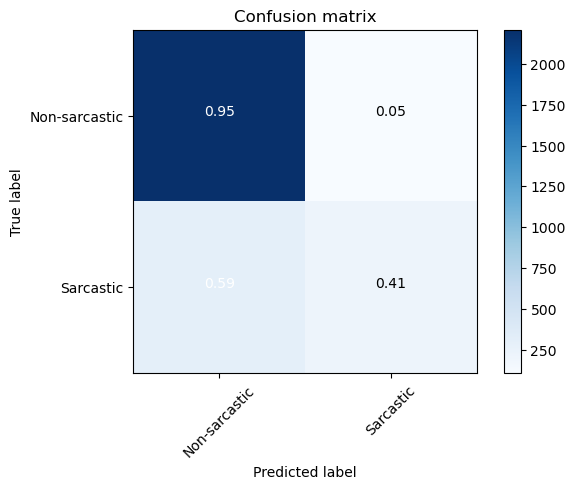

C:\Users\nimmi\AppData\Local\Temp\ipykernel_18384\3340382807.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


<Figure size 640x480 with 0 Axes>

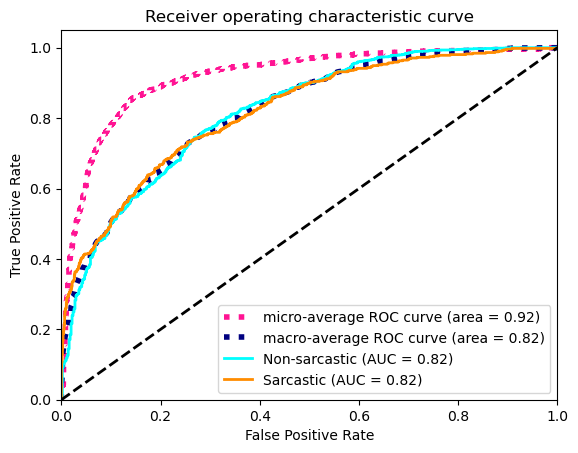

In [13]:
from sklearn import metrics
plt.clf()
cnf_matrix = metrics.confusion_matrix(label_index_test, predicted_prob.argmax(axis = 1))
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes = predictor.get_classes(), normalize = True)
plt.show()
# plt.savefig("confusion_roberta.pdf", format = 'pdf', dpi =1000)

plt.clf()
plot_AUC_ROC(label_test, predicted_prob)
plt.savefig("ROC_AUC_googlebert_mal.pdf", format = 'pdf', dpi =1000)


In [14]:
y_pred = predicted_prob.argmax(axis = 1)
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(label_index_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.8411276300766366
Recall: 0.8559801840056617
F1 Score: 0.8417667687402932


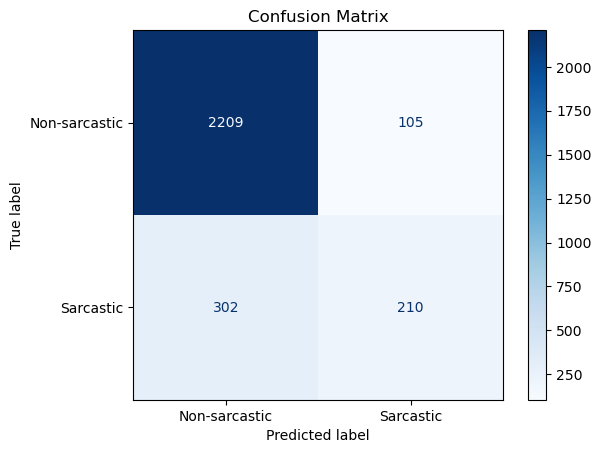

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(class_label_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_list)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
plt.savefig("confusion_goglebert_mal.pdf", format = 'pdf', dpi =1000)

In [14]:
from langdetect import detect

def detect_languages(text):
    try:
        return detect(text)
    except:
        return "unknown"

# For Malayalam-English dataset
language_switches = []

for text in text_test:  # malayalam_english_texts is your list of texts
    if "ml" in detect_languages(text) and "en" in detect_languages(text):  # Checks for Malayalam and English
        language_switches.append(text)


In [15]:
monolingual_texts = []
code_mixed_texts = []

for text in text_test:
    if "ml" in detect_languages(text) and "en" in detect_languages(text):
        code_mixed_texts.append(text)
    else:
        monolingual_texts.append(text)

In [20]:
len(monolingual_texts), len(code_mixed_texts)

(2824, 2)

In [23]:
from langdetect import detect
import nltk

# Download the tokenizer
nltk.download('punkt')

def detect_language(token):
    try:
        return detect(token)
    except:
        return "unknown"

def analyze_language_switching(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the sentence into words
    language_sequence = [detect_language(token) for token in tokens]  # Detect the language of each token
    
    # Identify switching points
    switches = 0
    for i in range(1, len(language_sequence)):
        if language_sequence[i] != language_sequence[i - 1]:  # Check if the language of consecutive tokens is different
            switches += 1
    
    return switches, tokens, language_sequence

# Example analysis for a list of texts
for sentence in text_test:  # text_test is your list of code-mixed texts
    switches, tokens, lang_sequence = analyze_language_switching(sentence)
    print(f"Text: {sentence}")
    print(f"Tokens: {tokens}")
    print(f"Language Sequence: {lang_sequence}")
    print(f"Number of switches: {switches}\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nimmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Text: Shavakallarayile Kuzhimaadathile Peril Oru Letter marach pedich lalettan ninnappo Onnu Nadungi
Tokens: ['Shavakallarayile', 'Kuzhimaadathile', 'Peril', 'Oru', 'Letter', 'marach', 'pedich', 'lalettan', 'ninnappo', 'Onnu', 'Nadungi']
Language Sequence: ['tr', 'sw', 'id', 'de', 'no', 'pl', 'it', 'it', 'fi', 'fr', 'id']
Number of switches: 9

Text: ഗീതു മോഹൻദാസ് മലയാള സിനിമക്കു നൽകുന്ന വമ്പൻ ഗിഫ്റ്റ് തന്നെ ആവും മൂത്തോന്
Tokens: ['ഗീതു', 'മോഹൻദാസ്', 'മലയാള', 'സിനിമക്കു', 'നൽകുന്ന', 'വമ്പൻ', 'ഗിഫ്റ്റ്', 'തന്നെ', 'ആവും', 'മൂത്തോന്']
Language Sequence: ['ml', 'ml', 'ml', 'ml', 'ml', 'ml', 'ml', 'ml', 'ml', 'ml']
Number of switches: 0

Text: Ente ponno ah sound🥰🥰 poli poli🤘
Tokens: ['Ente', 'ponno', 'ah', 'sound🥰🥰', 'poli', 'poli🤘']
Language Sequence: ['de', 'it', 'so', 'en', 'sl', 'sl']
Number of switches: 4

Text: Villain sharafudheen  ennu thonnunnavar likikkoooo
Tokens: ['Villain', 'sharafudheen', 'ennu', 'thonnunnavar', 'likikkoooo']
Language Sequence: ['fi', 'so', 'fr', 'fi', 'et']


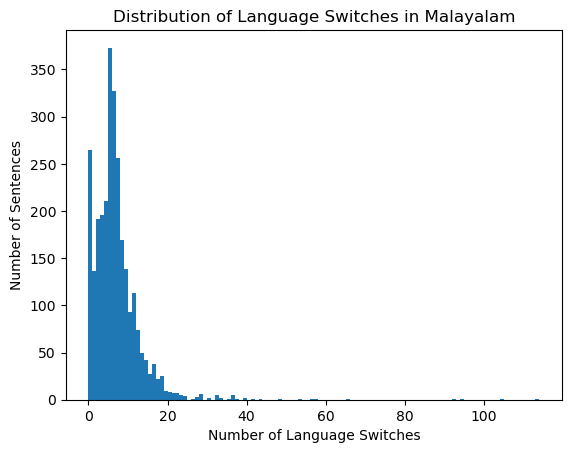

In [26]:
import matplotlib.pyplot as plt

# Assume switch_counts is a list of language switches per sentence
switch_counts = [analyze_language_switching(sentence)[0] for sentence in text_test]

plt.hist(switch_counts, bins=range(max(switch_counts) + 1))
plt.xlabel('Number of Language Switches')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Language Switches in Malayalam')
plt.show()


In [ ]:
from langdetect import detect

def detect_languages(text):
    try:
        return detect(text)
    except:
        return "unknown"

# Example on your Tamil-English dataset
language_switches = []

for text in text_test:  # tamil_english_texts is your list of texts
    if "ta" in detect_languages(text) and "en" in detect_languages(text):  # Checks for Tamil and English
        language_switches.append(text)

monolingual_texts = []
code_mixed_texts = []

for text in text_train:
    if "ta" in detect_languages(text) and "en" in detect_languages(text):
        code_mixed_texts.append(text)
    else:
        monolingual_texts.append(text)
